## Your Goal 
For this Episode of the Series, your task is to predict whether a customer continues with their account or closes it (e.g., churns). Good luck!

## Evaluation
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

## Submission File
For each id in the test set, you must predict the probability for the target variable Exited. The file should contain a header and have the following format:

## Features
* Balance-related Features 

We’ve introduced features such as IsBalanceZero, Low_Balance, Mid_Balance, and High_Balance to categorize customers based on their account balances.
* Salary-related Features

Similarly, we’ve categorized customers into Low_salary, Mid_salary, and High_salary groups based on their estimated salaries.
* Interaction Features

We’ve created interaction features like HasCard&Active, Interaction_Score, and Gender_Balance to capture relationships between different attributes.
* Credit Score and Age Groups

By binning credit scores and ages into categories, we’ve added credit_score_cat and Age_Group features, providing a holistic view of customer demographics.
* Utilization Ratios

We’ve calculated the Credit_Utilization_Ratio and Balance_to_Salary_Ratio to gauge customers' credit and financial behaviors
* Other Features

Additionally, we’ve incorporated features such as Inactive_Flag, Full_Utilization_Flag, Salary_Credit_Score_Interaction, and more to capture diverse aspects of customer interactions and behaviors.

In [67]:
import pandas as pd
import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, RocCurveDisplay, confusion_matrix, classification_report
from joblib import dump, load
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/Binary Classification with a Bank Churn Dataset/train.csv")
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [3]:
len(df)

165034

In [5]:
df.dtypes

id                   int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object

In [6]:
df.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [18]:
X = df.drop("Exited", axis=1)
y = df["Exited"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
object_columns = df.select_dtypes(include=["object"]).columns
preprocessor = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), object_columns), remainder="passthrough")

In [20]:
# Trying SGDClassifier

sgd_model = make_pipeline((preprocessor), (SGDClassifier()))
sgd_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Surname', 'Geography', 'Gender'], dtype='object'))])),
                ('sgdclassifier', SGDClassifier())])

In [21]:
sgd_model.score(X_train, y_train)

0.788399342558719

In [42]:
# Trying Kernel Approximation

rbf_model = make_pipeline((preprocessor), (RBFSampler()))
rbf_feature = rbf_model.fit_transform(X)
clf = SGDClassifier()
clf.fit(rbf_feature, y)
clf.score(rbf_feature, y)

0.7884011779390914

In [44]:
random_forest = make_pipeline((preprocessor), (RandomForestClassifier()))
random_forest.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Surname', 'Geography', 'Gender'], dtype='object'))])),
                ('randomforestclassifier', RandomForestClassifier())])

In [45]:
random_forest.score(X_train, y_train)

0.9999621289584706

In [46]:
random_forest.score(X_test, y_test)

0.8615445208592117

In [48]:
dump(random_forest, "bank_classification.joblib")

['bank_classification.joblib']

In [58]:
y_preds = random_forest.predict(X_test)

In [59]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92     26022
           1       0.77      0.49      0.60      6985

    accuracy                           0.86     33007
   macro avg       0.82      0.73      0.76     33007
weighted avg       0.85      0.86      0.85     33007



In [63]:
cm = confusion_matrix(y_test, y_preds)
cm

array([[25008,  1014],
       [ 3556,  3429]], dtype=int64)

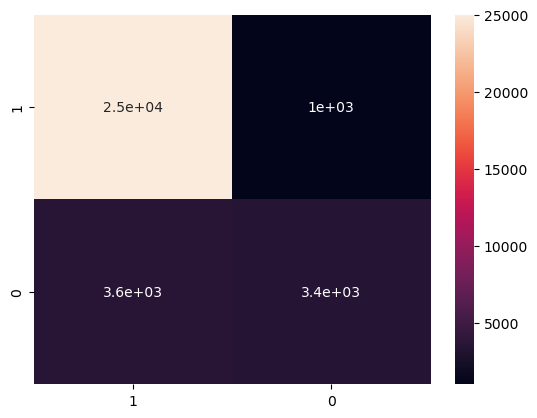

In [64]:
sn.heatmap(cm, annot=True, xticklabels=["1", "0"], yticklabels=["1", "0"]);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


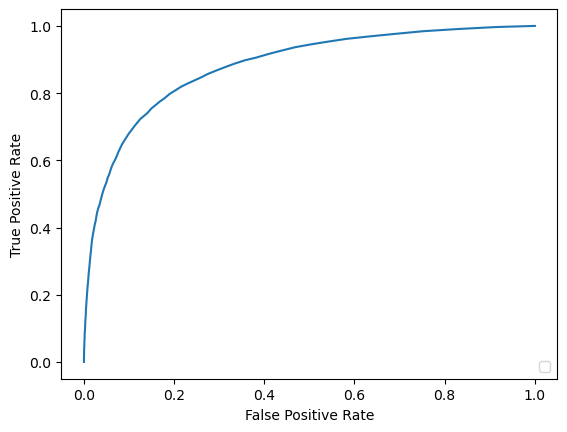

In [65]:
y_proba = random_forest.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_proba[:, 1])

RocCurveDisplay(fpr=fpr, tpr=tpr).plot();

# Random forest gives the best score


In [49]:
model = load("bank_classification.joblib")

In [50]:
test_df = pd.read_csv("../data/Binary Classification with a Bank Churn Dataset/test.csv")
test_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [54]:
y_preds = model.predict(test_df)
test_df["Estimated"] = pd.Series(y_preds)

In [55]:
test_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Estimated
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75,0
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27,1
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09,0
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57,0
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00,0


In [66]:
test_df["Estimated"].value_counts()

Estimated
0    96409
1    13614
Name: count, dtype: int64

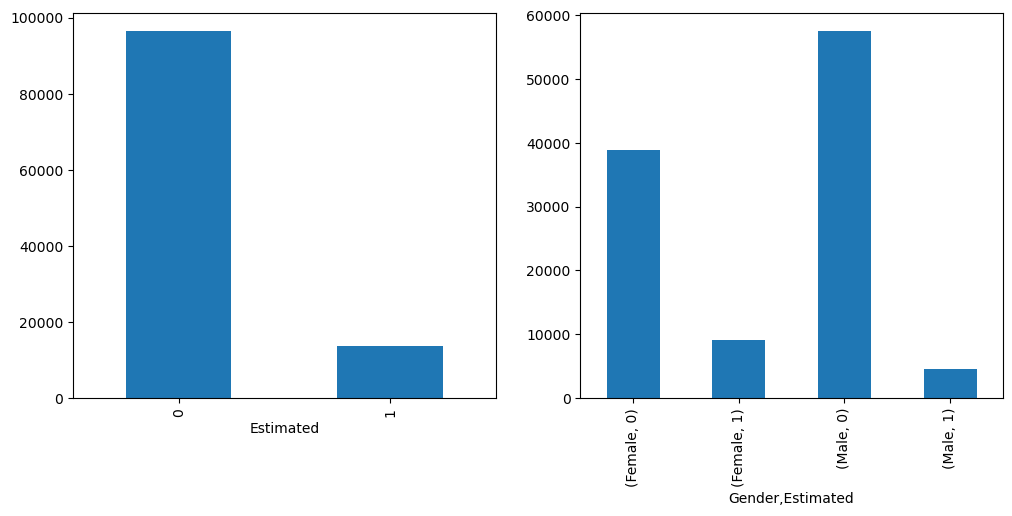

In [86]:
_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
test_df["Estimated"].value_counts().plot(kind="bar", ax=ax1)
gender_group = test_df.groupby("Gender")

gender_group["Estimated"].value_counts().plot(kind="bar", ax=ax2);